In [52]:
##### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import math
import os
from tensorflow.keras.models import Sequential,Model 
from tensorflow import keras
from tensorflow.keras import layers

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

github: https://github.com/colites/GAN-monet/upload

The purpose of this project is to be able to generate monet-style images. This can be done using various GAN architectures, but I will try to use a simple GAN. A simple GAN will analyze the monet style images and create new images that mimic the style using discriminators and generators. It requires a discriminator which tries to judge whether an image is generated or real and a generator which generates the images to try to fool the discriminator. The cycle where the generator gets better at generating images using the information gathered and the discriminator gets better at judging whether images are generated ends with images that are very similar to the original style of the original images. This is the main function of a simple GAN. Since the purpose of this project is to generate monet style images, the simple GAN is sufficient to complete the task well.

This problem can also be resolved using a cycleGAN architecture, which is more complex than a simple GAN architecture because it involves translation of monet style images into already existing images. The complexity comes from requiring two different generators and two different discriminators for each direction. This architecture translates the features of the input images into another set of already existing images, rather than completely generating new images.

To begin this project, we must first explore the given monet-images and see the interesting features that it has. Since I am doing a simple GAN, it is not necessary to deeply explore the other image set given for translation since this notebook will focus on generating completely new images rather than translating them. We will also be analyzing the jpg images only

In [3]:
monet_directory = '/kaggle/input/gan-getting-started/monet_jpg'
other_directory = '/kaggle/input/gan-getting-started/photo_jpg'

monet_image_files = os.listdir(monet_directory)
other_image_files = os.listdir(other_directory)

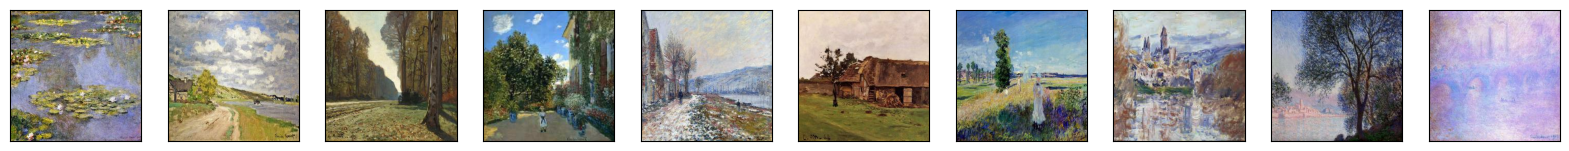

In [4]:
fig = plt.figure(figsize=(20, 5))
for i, image_file in enumerate(monet_image_files[:10]):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    im = Image.open(monet_directory + '/' + image_file)
    plt.imshow(im)

the width of the image is : 256
the height of the image is :256


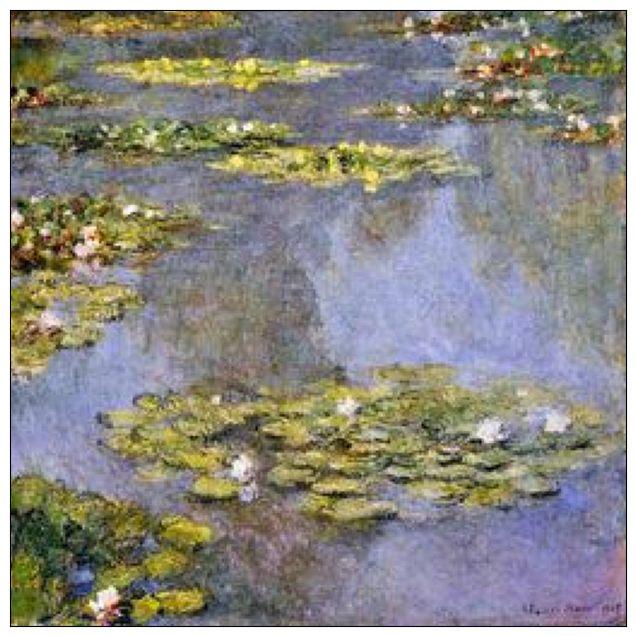

In [5]:
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(xticks=[], yticks=[])
im = Image.open(monet_directory + '/' + monet_image_files[0])
width, height = im.size
print(f'the width of the image is : {width}')
print(f'the height of the image is :{height}')
plt.imshow(im)

(256, 256, 3)


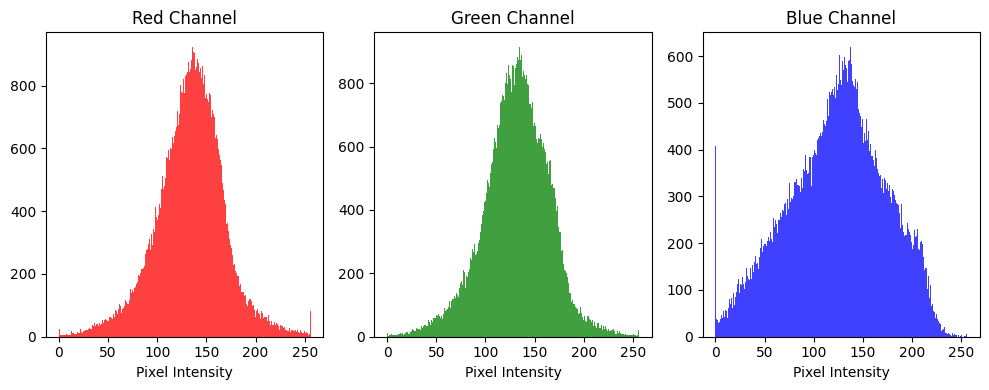

In [6]:
#### We will make a pixel intensity map to see the pixel intensity of the monet image above, the intensity can have patterns that will be picked up by the GAN
#### Inspired by the analysis done in https://www.codementor.io/@innat_2k14/image-data-analysis-using-numpy-opencv-part-1-kfadbafx6 
pixel_values = np.array(im)
print(pixel_values.shape)

# Separate the RGB channels
r, g, b = pixel_values[:,:,0], pixel_values[:,:,1], pixel_values[:,:,2]

# Plot the histogram of pixel intensities for each channel
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)  # Red channel
plt.hist(r.flatten(), bins=256, range=(0, 256), color='red', alpha=0.75)
plt.title('Red Channel')
plt.xlabel('Pixel Intensity')

plt.subplot(1, 3, 2)  # Green channel
plt.hist(g.flatten(), bins=256, range=(0, 256), color='green', alpha=0.75)
plt.title('Green Channel')
plt.xlabel('Pixel Intensity')

plt.subplot(1, 3, 3)  # Blue channel
plt.hist(b.flatten(), bins=256, range=(0, 256), color='blue', alpha=0.75)
plt.title('Blue Channel')
plt.xlabel('Pixel Intensity')

plt.tight_layout()
plt.show()

For comparison, we will look at the normal non monet images and also look at their details. 

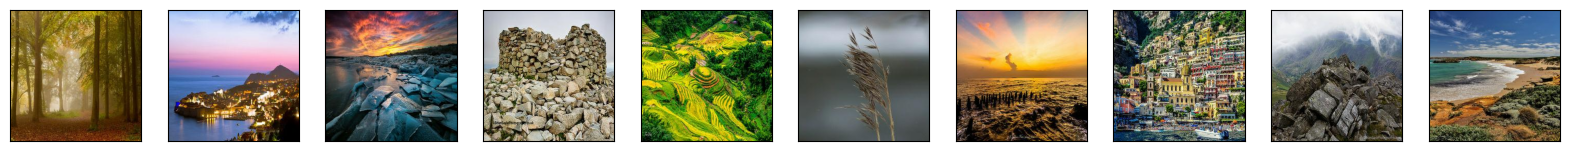

In [7]:
fig = plt.figure(figsize=(20, 5))
for i, image_file in enumerate(other_image_files[:10]):
    ax = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
    im = Image.open(other_directory + '/' + image_file)
    plt.imshow(im)

the width of the image is : 256
the height of the image is :256


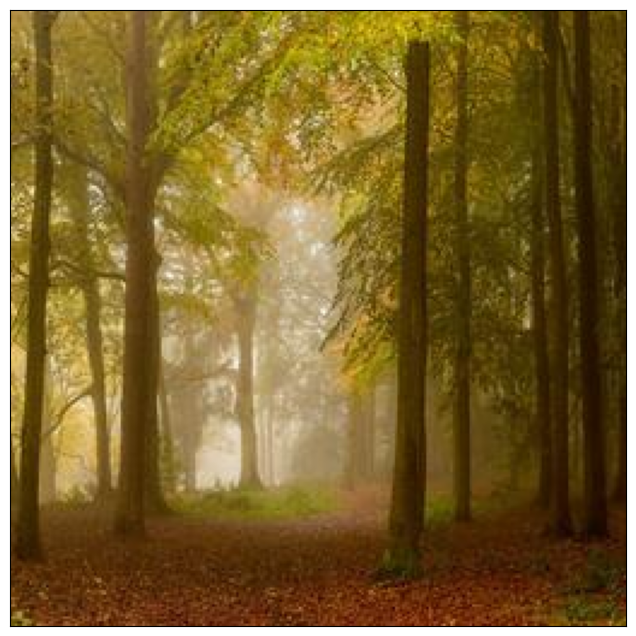

In [8]:
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(xticks=[], yticks=[])
im = Image.open(other_directory + '/' + other_image_files[0])
width, height = im.size
print(f'the width of the image is : {width}')
print(f'the height of the image is :{height}')
plt.imshow(im)

(256, 256, 3)


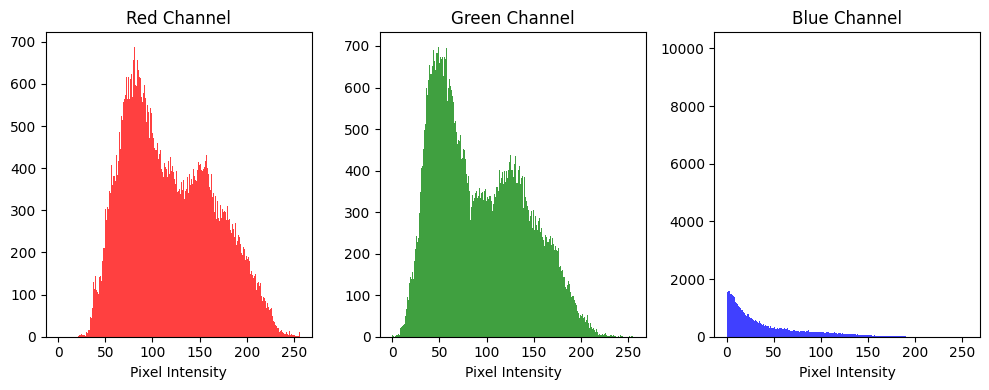

In [9]:
#### We will make a pixel intensity map to see the pixel intensity of the image above, the intensity can have patterns that will be picked up by the GAN
#### Inspired by the analysis done in https://www.codementor.io/@innat_2k14/image-data-analysis-using-numpy-opencv-part-1-kfadbafx6 
pixel_values = np.array(im)
print(pixel_values.shape)

# Separate the RGB channels
r, g, b = pixel_values[:,:,0], pixel_values[:,:,1], pixel_values[:,:,2]

# Plot the histogram of pixel intensities for each channel
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)  # Red channel
plt.hist(r.flatten(), bins=256, range=(0, 256), color='red', alpha=0.75)
plt.title('Red Channel')
plt.xlabel('Pixel Intensity')

plt.subplot(1, 3, 2)  # Green channel
plt.hist(g.flatten(), bins=256, range=(0, 256), color='green', alpha=0.75)
plt.title('Green Channel')
plt.xlabel('Pixel Intensity')

plt.subplot(1, 3, 3)  # Blue channel
plt.hist(b.flatten(), bins=256, range=(0, 256), color='blue', alpha=0.75)
plt.title('Blue Channel')
plt.xlabel('Pixel Intensity')

plt.tight_layout()
plt.show()

As can be seen in the comparison of RGB values above, the singular images had large differences in the pixel intensity for their respective RGB values. The normal image blue channel was much more skewed to lower pixel intensities while the monet image had much higher Blue pixel intensities. The Red and Green channel distributions also differed significantly. While these are only singular images in larger sets of data, it can be seen that RGB pixel intensities differed significantly when compared to each other. If there are RGB pixel intensity patterns in the monet images, then the GAN may use those patterns to eventually be able to mimic a monet image effectively. 

In [24]:
## function to load images from the directory and resize to target size, which is 256 in this case.
def load_images_from_directory(directory, target_size=(256, 256)):
    image_files = os.listdir(directory)
    images = []
    for image_file in image_files:
        image_path = os.path.join(directory, image_file)
        with Image.open(image_path) as img:
            img = img.resize(target_size)
            img_array = np.asarray(img)
            images.append(img_array)
    images = np.array(images)
    return images

## function to normalize images and load them in from the directory
def preprocess_monet_images(monet_directory):
    monet_images = load_images_from_directory(monet_directory, target_size=(256, 256))
    monet_images = (monet_images.astype('float32') - 127.5) / 127.5
    return monet_images

## function to plot an image
def plot_image(fake_image):
    plt.figure(figsize=(5,5))  
    image = (fake_image[0] * 0.5) + 0.5
    plt.imshow(image, aspect='auto')
    plt.axis('off')
    plt.show()

The neurons were picked as they are in the layers because I wanted to have the image be 256 x 256 like the actual monet images. I did not want to do downsampling and make the quality of the pictures go down. Batch normalization was done because it improves the training speed of the GAN, which is already very slow due to the large image dimensions and detail the monet images have. It also provides a small amount of regularization, since it adds noise. The sigmoid was placed because the generator output should be a probability between 0 and 1, this is for both the generator and discriminants.

This will initially get noise and then begin to actually churn out good pictures.

In [40]:
def build_generator(image_size=256, input_size=100):
    
     model = Sequential([
        layers.Dense(16 * 16 * 256, use_bias=False, input_shape=(input_size,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((16, 16, 256)),
        
        layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.Activation('sigmoid')
    ], name='generator')
    
     return model

We now build a Model with 4 Convolution layers. We use 4 convolution layers so that the generator is complex enough to be able to compete with the discriminator. We use leaky relu so that a little bit of information leaks, unlike relu which does not allow it. The neurons were picked as they are in the layers because I wanted to have the image be 256 x 256 like the actual monet images. I did not want to do downsampling and make the quality of the pictures go down. The discriminator cannot be too powerful, this was a constant issue when testing the GANS.

This will initially get noise and then begin to actually churn out good pictures.

In [42]:
def build_discriminator(data_shape=(256,256,3)):
    
    model = Sequential([
        layers.Input(shape=data_shape),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(32, kernel_size=(5, 5), strides=2, padding='same'),
        layers.Dropout(0.45),
        
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(64, kernel_size=(5, 5), strides=2, padding='same'),
        layers.Dropout(0.45),
        
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=(5, 5), strides=2, padding='same'),
        layers.Dropout(0.45),
        
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=(5, 5), strides=1, padding='same'),
        layers.Dropout(0.45),
        
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ], name='discriminator')
    
    return model

I got inspiration for doing something like an adversarial model from https://www.kaggle.com/code/shivansh002/gentle-introduction-to-gan. 
The notebook really helped grasp the steps of training a DCGAN, so these models are adaptations using similar concepts but for monet images instead of the MNIST dataset.

In essence, this is basically still a discriminator trying to find the fake images of the generator, but it is all wrapped up in one adversarial model.

I used adam as the optimizer because it has a adaptive learning rate. This is very useful for managing the generator since the discriminator's predictions will depend on how fast the generator can adapt and overcome the discriminator's knowledge.

In [53]:
def build_models():
        
    noise_size = 100

    generator = build_generator(input_size=noise_size)
    discriminator = build_discriminator(data_shape=(256, 256, 3))

    # Compile the discriminator
    discriminator.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

    # Make the discriminator not trainable when we are training the generator.
    discriminator.trainable = False

    # Adversarial model
    gen_input = keras.Input(shape=(noise_size,))
    G = generator(gen_input)  
    D = discriminator(G) 
    
    adversarial = Model(gen_input, D)
    adversarial.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

    # Reset discriminator to be trainable for its own training
    discriminator.trainable = True
    
    return generator, discriminator, adversarial

In [54]:
Generator, Discriminant, Adversarial = build_models()

In [ ]:
monet_images = preprocess_monet_images('/kaggle/input/gan-getting-started/monet_jpg')


**Conclusion**

In conclusion, I learned how difficult it is to make a GAN work. It is difficult to get the exact weights for stats like the learning rate because modifying one model to get better than the other might end up making it dominate too much. It needs to be a delicate balance and it is very difficult to be able to figure out that specific structure.

Next time, I am going to try more complex structures for both. This GAN structure ended up being too simple for the problem being solved, so the images that are generated are not very good. The problem ended up being that the discriminator was too good throughout the whole cycle, so the generator could not learn much. This is why the generated images are not very monet like. Next time, I think paying more attention to the kernel size might help me reduce overfitting or underfitting, since I regularly just go for a kernel of 3 or 5 and I never try out other kernel sizes, which play a large role in the training of GANs and many neural network architectures in general.



For the color channel graphs:
https://www.codementor.io/@innat_2k14/image-data-analysis-using-numpy-opencv-part-1-kfadbafx6

GAN inspired by:

https://www.kaggle.com/code/shivansh002/gentle-introduction-to-gan